# Baby Names done with Data

I need a good name for a baby!  It should be unique, but not too weird.  Lets analyze baby names in the US.

First get some baby names from the social security administration:

In [1]:
import urllib, os
if not os.path.exists('./names.zip'):
    urllib.request.urlretrieve('https://www.ssa.gov/oact/babynames/names.zip','./names.zip')

Next, extract the name info:

In [2]:
import zipfile
with zipfile.ZipFile('./names.zip', 'r') as zip_ref:
    zip_ref.extractall('./names/')

Load some libraries:

In [3]:
import glob, re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")  
np.random.seed(8675309)
%matplotlib inline


Read in the name files then take a peek to see what we have:

In [4]:

rawdfs = []
for f in glob.glob('./names/yob*.txt'):
    yr = int(re.findall('\\d+',f)[0])
    dat=pd.read_csv(f,names=['Name','Gender','Count'])
    dat['Year']=yr
    dat['Name']=dat['Name'].str.lower()
    dat['Pct'] = dat.groupby('Gender',group_keys=False).apply(lambda f: f.Count/f.Count.sum()*100)
    rawdfs.append(dat)
rawnames = pd.concat(rawdfs)
names = rawnames.pivot_table(index = ['Year','Name'], columns = 'Gender', values=['Count','Pct'], fill_value=0).reset_index()
names.index.rename('index',inplace=True)
names.columns = names.columns.map(' '.join).str.strip()
names.head()


,Year,Name,Count F,Count M,Pct F,Pct M
index,,,,,,
0,1880,aaron,0,102,0.000000,0.092316
1,1880,ab,0,5,0.000000,0.004525
2,1880,abbie,71,0,0.078027,0.000000
3,1880,abbott,0,5,0.000000,0.004525
4,1880,abby,6,0,0.006594,0.000000


# Ok, we have the data, so lets explore
How do these name things work? Are there rules, or at least trends?

Next, inspect the data 
how does the number of births change in a year?
what is the proportion of M/F

In [5]:
print(names.sample(20))
print("number of rows in data: {}".format(names.shape[0]))
print("number of unique names: {}".format(len(set(names.Name))))

         Year     Name  Count F  Count M     Pct F     Pct M
index                                                       
1122311  1996    maika        0        7  0.000000  0.000370
1201850  1999    payam        0        5  0.000000  0.000260
1371091  2005   meikhi        0        5  0.000000  0.000250
1530493  2010  marelyn       33        0  0.001858  0.000000
892366   1986  gardner        0        8  0.000000  0.000434
194097   1924   carlyn       21        7  0.001682  0.000618
1188321  1999    davee        0        5  0.000000  0.000260
1660963  2014  savanna      672        0  0.037663  0.000000
1409613  2006   tejuan        0        5  0.000000  0.000243
1600952  2012     tara      335        0  0.019041  0.000000
1395676  2006  jolicia        5        0  0.000263  0.000000
846216   1983   romell        0       27  0.000000  0.001506
104734   1914  eufelia        6        0  0.000788  0.000000
574220   1965   iliana       33        0  0.001870  0.000000
1544550  2011    arieh  

Add some new calculated columns to the dataframe:

In [6]:
names['namelength']=names.Name.apply(len)
names['Count']=names['Count M']+ names['Count F']

Create a new data frame that summarizes some annual metrics, number of unique names, total names, and the top names in each year:

In [7]:
# calculate some annual stats:
annual_metrics = names.groupby('Year').agg({'Name':lambda x: x.nunique(),'Count F':sum,'Count M':sum})
annual_metrics['Unique, M'] = names.groupby('Year').apply(lambda x: x.loc[x['Count M']>0,'Name'].nunique())
annual_metrics['Unique, F'] = names.groupby('Year').apply(lambda x: x.loc[x['Count F']>0,'Name'].nunique())
annual_metrics['Total'] = annual_metrics['Count F']+annual_metrics['Count M']
annual_metrics['Top, M'] = names.groupby('Year').apply(lambda x: x.loc[x['Count M'].idxmax(),'Name'])
annual_metrics['Top, F'] = names.groupby('Year').apply(lambda x: x.loc[x['Count F'].idxmax(),'Name'])

annual_metrics.loc[1940:2017:5,:]

,Name,Count F,Count M,"Unique, M","Unique, F",Total,"Top, M","Top, F"
Year,,,,,,,,
1940,7984,1143466,1159091,3936,5025,2302557,james,mary
1945,8080,1307058,1345744,3784,5241,2652802,james,mary
1950,9281,1713054,1790390,4195,6110,3503444,james,linda
1955,10010,1955270,2059866,4398,6729,4015136,michael,mary
1960,10751,2022001,2131990,4595,7330,4153991,david,mary
1965,10836,1765114,1860668,4421,7534,3625782,michael,lisa
1970,13408,1748153,1858974,5431,9351,3607127,michael,jennifer
1975,15383,1457921,1562109,6336,10614,3020030,michael,jennifer
1980,17729,1660441,1784689,7294,12163,3445130,michael,jennifer


# Inspect some names over time
With the data in hand, lets take a look at a few names for boys and girls

In [8]:
#https://github.com/bokeh/bokeh/tree/master/examples/howto/notebook_comms
#https://bokeh.pydata.org/en/latest/docs/user_guide/plotting.html
#https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#basic-tooltips
#https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#formatting-tooltip-fields
boynames=['walter','james','jacob','otto','anakin']

from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.transform import linear_cmap,factor_cmap
output_notebook()

TOOLTIPS = [
    ("Count, M", "@{Count M}"),
    ("Count, F", "@{Count F}"),
    ("(x,y)", "(@Year{0}, $y)"),
    ("Name", "@Name"),
]
p = figure(title="names over time", height=480, width=600,
           background_fill_color='#efefef',tooltips = TOOLTIPS,y_axis_type='log')
p.scatter('Year', 'Pct M',fill_alpha=0.8,source=names.loc[names.Name.isin(boynames),:],
             color=factor_cmap('Name', 'Category10_10', boynames))

show(p)

Loading BokehJS ...

In [9]:
girlnames=['eva','kathleen','erin','thea','katniss']
p = figure(title="names over time", height=480, width=600,
           background_fill_color='#efefef',tooltips = TOOLTIPS,y_axis_type='log')
p.scatter('Year', 'Pct F',fill_alpha=0.8,source=names.loc[names.Name.isin(girlnames),:],
             color=factor_cmap('Name', 'Category10_10', girlnames))

show(p)

# The Optimal Name
To have something be an optimum, there must be some quantitative criteria.  For me, I wanted to find girl names that are <0.05% in popularity but have been increasing in popularity over the years 2013-2017.  Lets go slow here and inspect the data as we filter and sort.

First make a subset of the names data frame to select names that are between 0.01% to 0.1% in girl's popularity, for the years 2013 and 2017:


In [10]:
namesnow = names.loc[(names['Pct F']<1e-1)& (names['Pct F']>1e-2)&((names.Year==2017) |(names.Year==2013)) ,:]

In [11]:
namesnow.head()

,Year,Name,Count F,Count M,Pct F,Pct M,namelength,Count
index,,,,,,,,
1604361,2013,aanya,230,0,0.013122,0.0,5,230
1604470,2013,abbey,222,0,0.012666,0.0,5,222
1604473,2013,abbie,245,0,0.013978,0.0,5,245
1604477,2013,abbigail,364,0,0.020767,0.0,8,364
1604485,2013,abby,906,0,0.051689,0.0,4,906


Next, pivot the data to have a column for each year:

In [12]:
name_piv = pd.pivot_table(namesnow,values=('Pct F'),index=['Name'],columns=['Year'])

In [13]:
name_piv.sample(5)

Year,2013,2017
Name,,
rosemary,0.032120,0.040336
azaria,0.015918,0.014683
linda,0.025388,0.023563
julissa,0.039594,0.025768
pyper,0.013864,0.010447


Now, add a column for the difference between the two years, and sort the table:

In [14]:
name_piv['% change']=(name_piv[2017]-name_piv[2013])/name_piv[2013]*100

name_piv.sort_values('% change',ascending=False).head(10)

Year,2013,2017,% change
Name,,,
thea,0.012152,0.069064,468.326501
ophelia,0.010555,0.044340,320.099515
remi,0.017971,0.074055,312.069690
freya,0.016032,0.062448,289.526045
margot,0.015290,0.049912,226.433113
magnolia,0.014719,0.047242,220.948425
remington,0.013807,0.044050,219.048686
amara,0.028298,0.086997,207.433017
everleigh,0.016830,0.046778,177.935215


At the top of the list? Thea!

# The properties of Names

This exercise got me thinking, what are the properties of names in the US?  It is a big decision for any parent, are there trends in the data that can reveal a bit about our culture?  To start, lets plot the total number of unique names by year:

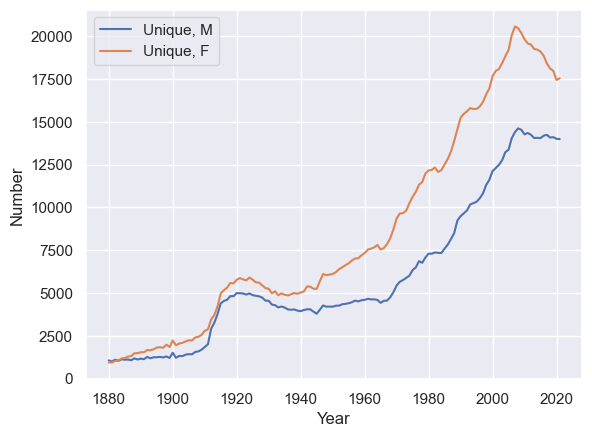

In [15]:
annual_metrics.reset_index().plot('Year',['Unique, M','Unique, F'])
plt.ylabel('Number');

There has been a big increase in names for both girls and boys over the years, with girls having more name diversity, in the period 1940-2005 for girls, and the period 1965-2005 for boys the number of different names grew quickly. Recently the number of names used has stalled.

That describes the kinds of names used, but how about the actual distribution?  Some first names will be more popular than others and because the data only tracks names used 5 times or more, more names will meet this threshold as the population grows.

In [16]:
from ipywidgets import interact

@interact(year = (1940,2015,5),xlim = (5,1000,25))
def plot_func(year,xlim):
    plt.plot(names.loc[(names.Year == year),('Pct M')].sort_values(ascending=False).cumsum().values,label = 'M')
    plt.plot(names.loc[(names.Year == year),('Pct F')].sort_values(ascending=False).cumsum().values,label = 'F')
    plt.legend()
    plt.xlim([0,xlim])
    plt.xlabel('Top N names')
    plt.ylabel('Cumulative fraction')


interactive(children=(IntSlider(value=1975, description='year', max=2015, min=1940, step=5), IntSlider(value=4…

The interactive plots in Jupyter is nice to scan across different ranges and build intuition.  Plotting the cumulative fraction is a useful way to look at how the name popularity is distributed for each year.  The trends are surprising - in 1940 half of all boys had one of about 20 names, while half of all girls had one of 40 names.  In 2015, the diversity in number of names increased 5 fold to ~120 and ~220, respectively.

What is the gini coeffieicent for the names each year?

In [17]:
names

,Year,Name,Count F,Count M,Pct F,Pct M,namelength,Count
index,,,,,,,,
0,1880,aaron,0,102,0.000000,0.092316,5,102
1,1880,ab,0,5,0.000000,0.004525,2,5
2,1880,abbie,71,0,0.078027,0.000000,5,71
3,1880,abbott,0,5,0.000000,0.004525,6,5
4,1880,abby,6,0,0.006594,0.000000,4,6
...,...,...,...,...,...,...,...,...
1873703,2021,zyriah,8,0,0.000492,0.000000,6,8
1873704,2021,zyrie,0,6,0.000000,0.000346,5,6
1873705,2021,zyrihanna,5,0,0.000307,0.000000,9,5


In [18]:
%%time
#https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python/48999797#48999797

def gini(x, w=None):
    # Array indexing requires reset indexes.
    x = pd.Series(x.loc[x>0]).reset_index(drop=True)
    if w is None:
        w = np.ones_like(x)
    w = pd.Series(w).reset_index(drop=True)
    n = x.size
    wxsum = sum(w * x)
    wsum = sum(w)
    sxw = np.argsort(x)
    sx = x[sxw] * w[sxw]
    sw = w[sxw]
    pxi = np.cumsum(sx) / wxsum
    pci = np.cumsum(sw) / wsum
    g = 0.0
    for i in np.arange(1, n):
        g += pxi.iloc[i] * pci.iloc[i - 1] - pci.iloc[i] * pxi.iloc[i - 1]
    return g

def gini_cols(x,cols):
    return [gini(x[col]) for col in cols]

gini_s = names.groupby(['Year']).apply(lambda x: gini_cols(x,['Count F','Count M']))
gini_df = pd.DataFrame(gini_s.to_list(), columns=['Gini F','Gini M'],index=gini_s.index)

CPU times: user 40.3 s, sys: 212 ms, total: 40.5 s
Wall time: 40.8 s


<AxesSubplot: xlabel='Year', ylabel='Gini Coefficient'>

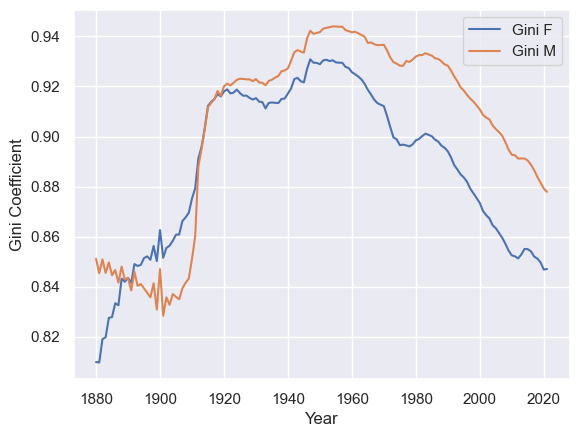

In [19]:

gini_df.plot(ylabel='Gini Coefficient')

I had a hard time finding real research into baby naming trends, but based off of one article [here](https://qz.com/1440188/the-rise-of-the-4-letter-baby-name), lets recreate the plot the length of names (weighted by popularity) over time, then really dig deep to see what is going on...

<AxesSubplot: title={'center': 'Average Name Length Over Time'}, xlabel='Year'>

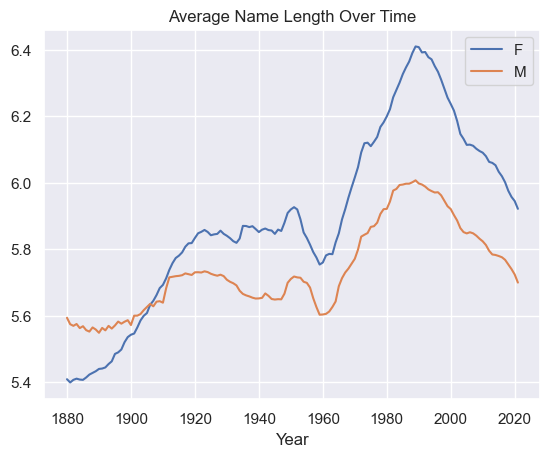

In [20]:
names.groupby(by=['Year']).apply(lambda x: pd.Series([np.sum(x['namelength']*x['Pct F']/100),
                                            np.sum(x['namelength']*x['Pct M']/100)],index = ['F','M'])).reset_index().plot('Year',['F','M'],title='Average Name Length Over Time')


Lets go a step further and look at the distribution of name length popularity for a given year

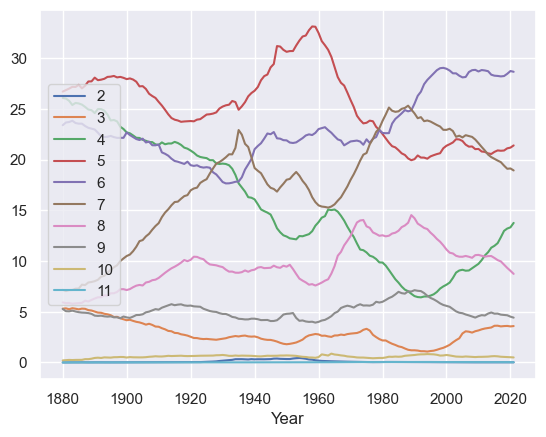

In [21]:
len_dist = names.groupby(by=['Year','namelength']).agg({'Pct F':sum,'Pct M':sum}).reset_index()
#@interact(nl=(2,15))
#def customplot(nl): 

len_dist.loc[len_dist.namelength<12,:].pivot_table(index='Year',columns='namelength',values='Pct F').plot()
plt.legend(loc='center left')

This is an ugly plot, but it shows since the 1980s 4-letter names are gaining, at the expense of 7-letter names

# Son-rise: how many \*son names are there?
A suffix that is increasingly common for names is -son (Anderson, Grayson, Bryson, etc). How have the number of names  grown over time?

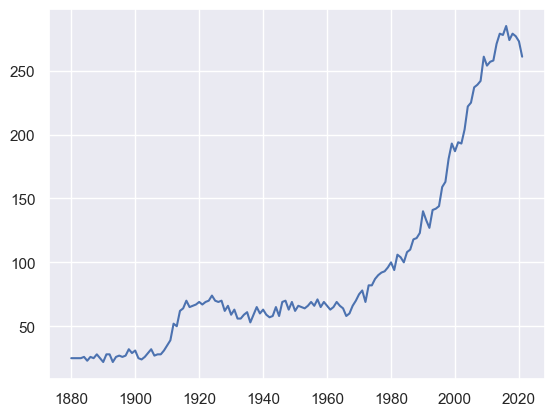

In [22]:
number_son_names = names.loc[names.Name.str.contains('son$'),:].groupby('Year').agg({'Name':len})

plt.plot(number_son_names.index,number_son_names.Name)

Wow, there has been a huge rise in the kinds of names use starting in the late '60s... How about the number of new babies born with one of the names?

/var/folders/z3/y6k33tz92rd9hcgsd40kc_7h0000gn/T/ipykernel_46137/1769536022.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sons = names.loc[names.Name.str.contains('son$'),:].groupby('Year').agg(np.sum)


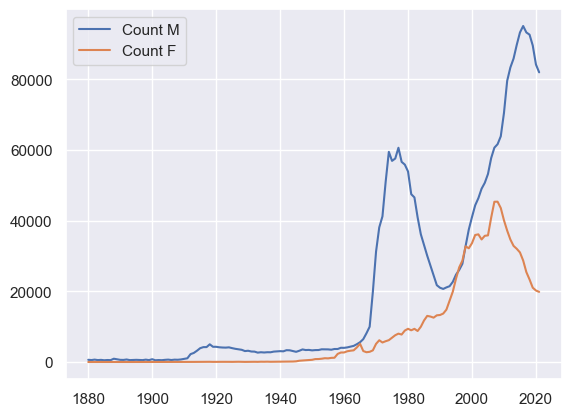

In [23]:
sons = names.loc[names.Name.str.contains('son$'),:].groupby('Year').agg(np.sum)
plt.plot(sons.index,sons['Count M'],label='Count M')
plt.plot(sons.index,sons['Count F'],label='Count F')
plt.legend()

Whoa, what is going on with the sudden rise and fall for boys in 1970-1990? Lets take a closer look at \*son names at the start of four decades:

In [24]:
names.loc[(names.Year.isin([1970,1980,1990,2000]))&names.Name.str.contains('son$'),:].sort_values('Count M',ascending = False).head(5)

,Year,Name,Count F,Count M,Pct F,Pct M,namelength,Count
index,,,,,,,,
786083,1980,jason,306,48178,0.018429,2.699518,5,48484
632699,1970,jason,114,27282,0.006521,1.467584,5,27396
975852,1990,jason,42,10694,0.002212,0.520734,5,10736
1220331,2000,jason,24,9776,0.001322,0.497843,5,9800
1226657,2000,mason,148,6516,0.008151,0.331828,5,6664


In the 1970-1990 range Jason dominates the \*son names, but then drops to 20% of its peak by 2000, what's going on?

## Jason / Alexander

Ok, so the number of new Jasons stalled in the late 70s then dropped preciptiously around [1980](https://www.imdb.com/title/tt0080761/).  What names took Jason's place? One way to get a clue would be to see which names were correlated with Jason in the years 1980-2000.  Because most correlation calculations will do all pairs, the calculation can be too slow when too many names are used.  Lets filter to the years we are interested in and keep only the names with some minimum level of popularity.


In [25]:
df_subset = names.loc[(names.Year >1980) &(names.Year < 2000)&(names['Count M']>4000),:].pivot_table(index='Year',columns='Name',values='Count M')

<AxesSubplot: xlabel='Name'>

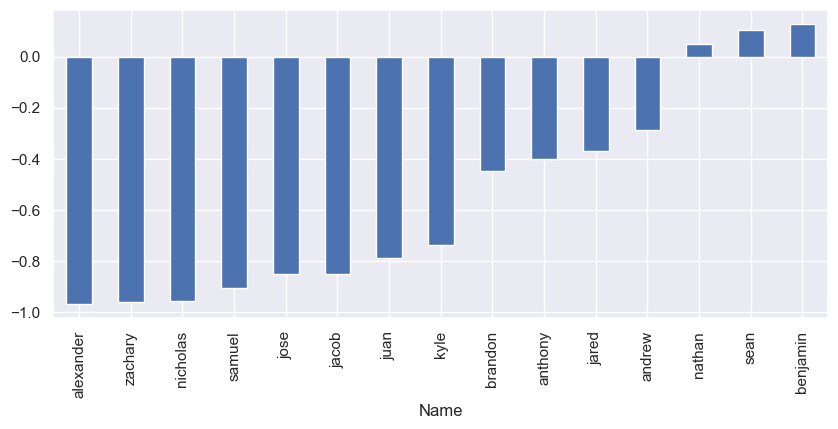

In [26]:
plt.figure(figsize = (10,4))
df_subset.dropna(how='any',axis=1).corr().loc['jason',:].sort_values(ascending=True).head(15).plot(kind='bar')


From the plot of name correlations, the name that is most anti-correlated with Jason is Alexander, followed by Zachary and Nicholas.  Correlation isn't causation, and we havent looked at any absolute numbers, but it provides some clue to the names that were rising as Jason declined.

# How many names swtich popularity between genders?

Plot the F/M ratio of names on the x-axis to track the gender popularity of names, color the lines by the overall popularity of the name.

In [27]:
names['F_Ratio'] = names['Count F']/(names['Count F']+names['Count M'])
nameswitch = names.loc[names['Count']>1000].groupby('Name').apply(lambda x: np.max(x['F_Ratio'])-np.min(x['F_Ratio']))
nameswitch_all = names.loc[names['Count']>10].groupby('Name').apply(lambda x: np.max(x['F_Ratio'])-np.min(x['F_Ratio']))

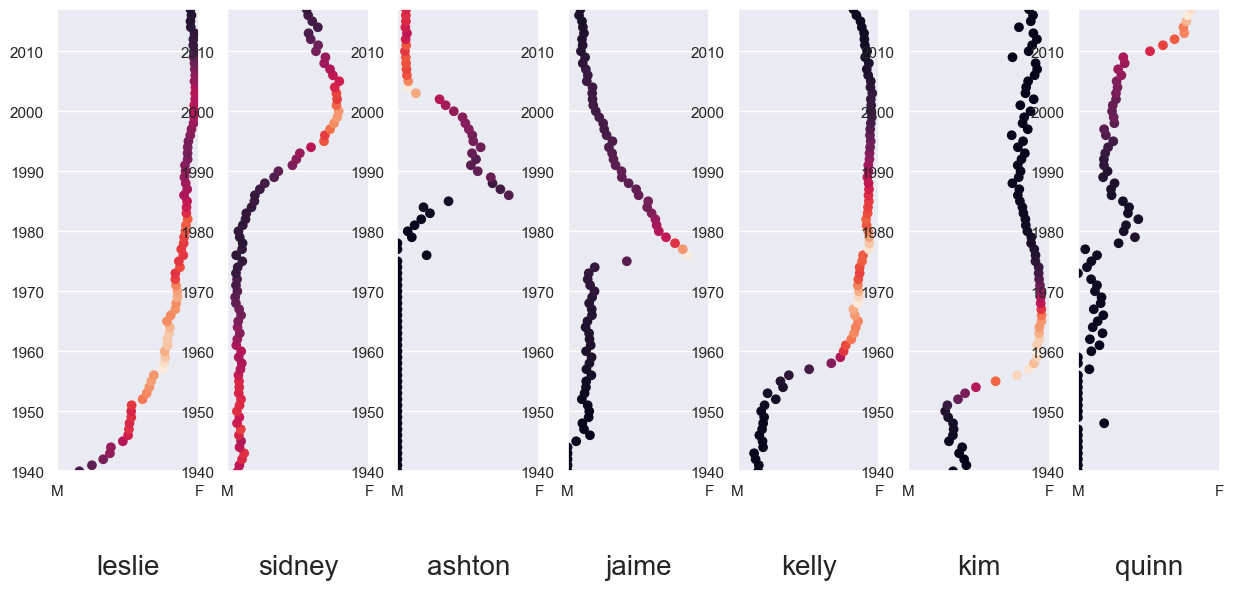

In [28]:
plot_names = nameswitch.loc[nameswitch>0.6].sort_values(ascending=False)
plt.figure(figsize=(15,6))
for ix,pn in enumerate(plot_names.index):
    plt.subplot(1,len(plot_names),ix+1)
    
    plt.scatter(names.loc[names.Name == pn,'F_Ratio'],names.loc[names.Name == pn,'Year'],
             c=names.loc[names.Name == pn, 'Count F']+names.loc[names.Name == pn, 'Count M'])
    plt.xlim([0,1])
    plt.ylim([1940,2017])
    plt.xticks(ticks=[0,1],labels=['M','F'])
    plt.xlabel(pn,rotation=0,labelpad = 40,size=20)


Only two of the top names had their popularity coincidie with the switch from male to female.  Kim swiched from male to female in the mid-1950s coinciding with the poplulariy of actress Kim Novak.  Jaime jumped in 1976, matching the popularity of the TV series *The Bionic Woman*  Ashton is interesting as it went from unpopular boys name to unpopular girls name, and then back to popular boys name in the early 2000's along with the popularity of actor Ashton Kutcher.

# Pop names
So we've seen that the change in some names can be attribued to popular movies and tv shows, but is this a recent phenomena? There are tens of thousands of names, how do we check them all?

In [29]:
from scipy.stats import zscore
def jumps_up(x):
    if x.shape[0]>50:  # min number of years
        zs = zscore(np.gradient(x.Count,x.Year))
        ix = np.argmax(zs)
        yx = x.Year.iloc[ix]
        mx = zs[ix]
        return([mx,yx,x.loc[x.Year==yx,'Count'].values[0]])
    else:
        return(None)
def jumps_dn(x):
    if x.shape[0]>50:
        zs = zscore(np.gradient(x.Count,x.Year))
        ix = np.argmin(zs)
        yx = x.Year.iloc[ix]
        mx = zs[ix]
        return((mx,yx,x.loc[x.Year==yx,'Count'].values[0]))
    else:
        return(None)
pops = names.groupby('Name').apply(jumps_up).dropna()
pops_df= pd.DataFrame(pops.to_list(), columns=['Z score','Year','Number that Year'],index=pops.index)
pops_df.loc[pops_df['Z score']>8].sort_values('Number that Year',ascending=False).head(30)

,Z score,Year,Number that Year
Name,,,
shirley,8.358909,1934,23132
cindy,8.283995,1956,9998
addison,8.858923,2006,8066
warren,8.359595,1920,5517
shelby,8.678561,1990,3871
walker,9.351558,2021,2968
franklin,8.548463,1932,2763
adeline,8.386474,2015,2408
wesley,8.056430,1976,2171


Some googling of these names with big increases found some possible causes for the sudden increase in popularity:
- selena, 1994; rising popularity of the [singer](https://en.wikipedia.org/wiki/Selena_(singer))
- franklin, 1932, during the [1932 US Presidential Election](https://en.wikipedia.org/wiki/1932_United_States_presidential_election)
- shirley, 1934, [Peak of Shirley Temple's popularity](https://en.wikipedia.org/wiki/Shirley_Temple)
- calista, 1998, [Calista Flockhart](https://en.wikipedia.org/wiki/Calista_Flockhart)
- dawson, 1998, [*Dawson's Creek*](https://en.wikipedia.org/wiki/Dawson%27s_Creek)
- cindy, 1956, a popular [song](https://en.wikipedia.org/wiki/Cindy,_Oh_Cindy)
- warren, 1920, following the [1920 US Presidential Election](https://en.wikipedia.org/wiki/1920_United_States_presidential_election)
- mariah, 1990, the start of the the pop and R&B [singer's](https://en.wikipedia.org/wiki/Mariah_Carey_(album)) career


In [30]:

drops = names.groupby('Name').apply(jumps_dn).dropna()
drops_df= pd.DataFrame(drops.to_list(), columns=['Z score','Year','Number that Year'],index=drops.index)
drops_df.loc[drops_df['Z score']<-6].sort_values('Z score',ascending=True).head(30)

,Z score,Year,Number that Year
Name,,,
hillary,-8.273007,1993,1071
elsa,-7.792297,2015,658
forrest,-7.442428,1995,880
jonas,-7.323791,2009,811
wilson,-7.265079,1919,853
hilary,-7.209775,1993,350
truman,-7.100473,1946,286
katherin,-7.097130,1990,55
kizzie,-7.013943,1977,286


Some more googling of the names that had sudden declines found that many were correcting from a sharp rise in popularity while others had some negative associations:

- hillary, 1993 : rise and drop surrounding the [1992 US Presidential Election](https://en.wikipedia.org/wiki/1992_United_States_presidential_election)
- elsa, 2015 aftermath of popularity spike due to [*Frozen*](https://www.imdb.com/title/tt2294629/) (annabel dropped too...)
- Both woodrow & wilson, 1919 [During the US President's term](https://en.wikipedia.org/wiki/Woodrow_Wilson)
- truman, 1946 rose and fell as [Truman became president](https://en.wikipedia.org/wiki/Harry_S._Truman) 
- arsenio, 1990 correction to rise in popularity of [Arsenio Hall](https://www.imdb.com/name/nm0002119/)
- garfield, 1882 dropped after the [US President was assassinated](https://en.wikipedia.org/wiki/James_A._Garfield)
- lyndon, 1965 correction from [1964 US Presidential Election](https://en.wikipedia.org/wiki/Lyndon_B._Johnson)
- audie, 1957 correction to rise in the popularity of [Audie Murphy](https://en.wikipedia.org/wiki/Audie_Murphy)
- kizzie, 1977 drop following the spike in popularity of [*Roots*](https://en.wikipedia.org/wiki/Roots_(1977_miniseries))
- marian, 1955 aftermath of the 1954 [Marian year](https://en.wikipedia.org/wiki/Marian_year)
- forrest, 1995 [*Forrest Gump*](https://en.wikipedia.org/wiki/Forrest_Gump)

This adds more support to the idea that parents who choose names are influenced by the culture at the time, this seems to be nothing new!

In [31]:
#For fun, how many names are palindromes?

p=names.Name.map(lambda x: str(x)==str(x)[::-1])
names.loc[p,:].groupby(['Name']).agg('median').sort_values('Count',ascending=False).head(10)

,Year,Count F,Count M,Pct F,Pct M,namelength,Count,F_Ratio
Name,,,,,,,,
anna,1950.5,5358.0,17.0,0.451087,0.001243,4.0,5369.5,0.99667
ada,1950.5,655.0,0.0,0.047792,0.000000,3.0,655.0,1.00000
hannah,1950.5,301.0,0.0,0.074279,0.000000,6.0,301.0,1.00000
ana,1951.0,258.0,0.0,0.014326,0.000000,3.0,258.0,1.00000
elle,2001.0,197.0,0.0,0.010943,0.000000,4.0,197.0,1.00000
aja,1997.5,178.0,0.0,0.010472,0.000000,3.0,181.0,1.00000
otto,1950.5,0.0,176.0,0.000000,0.017044,4.0,176.0,0.00000
ava,1950.5,159.5,0.0,0.015919,0.000000,3.0,159.5,1.00000
eve,1950.5,135.0,0.0,0.011284,0.000000,3.0,135.0,1.00000


# Make new names with a Neural Net

So, we have seen that 

  1. Name diversity has increased over time, and
  2. Name length is decreasing
  
That puts the pressure on creating shorter, novel names... How can that need be met?

Let's get to work making some more names: build LSTM model for girl's names using the Keras text generation [example](https://github.com/keras-team/keras-io/blob/master/examples/generative/lstm_character_level_text_generation.py) as a starting point:

In [32]:
%%time
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import io

text = ' '.join(names.loc[names['Count F']>4,'Name'].unique())
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 10
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM - dial down the LSTM size, we dont need a lot for a name
print('Build model...')
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(16),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.03)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)




2023-02-27 10:39:15.384255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


total chars: 27
nb sequences: 175934
Vectorization...


<timed exec>:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Build model...


2023-02-27 10:39:19.963261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 3.02 s, sys: 684 ms, total: 3.71 s
Wall time: 4.91 s


Next lets get a view of the model before fitting - it has been initialized with random parameters 

In [33]:
%%time
epochs = 101
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    if epoch%50 == 0:
        print()
        print("Generating text after epoch: %d" % epoch)

        start_index = random.randint(0, len(text) - maxlen - 1)
        for diversity in [0.3, 1.0, 1.2]:
            print("...Diversity:", diversity)

            generated = ""
            sentence = text[start_index : start_index + maxlen]
            print('...Generating with seed: "' + sentence + '"')

            for i in range(400):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.0
                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]
                sentence = sentence[1:] + next_char
                generated += next_char

            print("...Generated: ", generated)
            print()

1375/1375 [==============================] - 7s 4ms/step - loss: 1.9613

Generating text after epoch: 0
...Diversity: 0.3
...Generating with seed: "ah anastai"
...Generated:  na annaie andera amira amiah amiah amilea amia amita aleina aleen aleel aleena aletha aliele aleshia alee alee alelia alesha aleshia alie alani aletha alayana alie amia amikah amiah amiyah annie annette annesta annika ashelle aria asharia arisha arisha ariele arisha arlenne ariyah akiah arishia arisha ariesha akeria artia arianna arianna arane ariana arielia ariele artia arian arice arian arrie ar

...Diversity: 1.0
...Generating with seed: "ah anastai"
...Generated:   amose atyasha ampik annalethh arbera arici ampa amicek amerah aletrah aley alvi amye alxniah aleena alerita alonica elvey gionie giai bynnya gumia oahiah beria pakiavia bymyne borica byrnete byoune baorah bathuybina kenyin krimia kghiah shyra shinmele shimeka sharion shi shendiri sheshnea shethnetta callynn jeniena kelyya kyyah juxenyci kamostellya 

It looks like the model can reproduce the data, as the diversity parameter is increased, the results go from repetitive to more random.

With the trained model, the plan will be to generate some predictions, then use `set` to filter out names that are english words or are in the training set:

Lets rerun that code, with a conservative diversity (if any existing names are repeated, we'll filter them out)

In [34]:
%%time
np.random.seed(8675309)
generated=''
diversity=0.8
sentence='peanut emu'  # seed text to kick off predictions
for i in range(4000):
    x = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char
    


<timed exec>:49: RuntimeWarning: divide by zero encountered in log


CPU times: user 2min 39s, sys: 8.84 s, total: 2min 47s
Wall time: 2min 44s


In [35]:
generated[1:300]

'ia emica emindy elceleann eaeina eaja elenise ella emerisha emanie emeliana edika eden ewanna emaniya emo emique emily emhila eminna emcella emallee evanah fasaly fasia failica fadika faie fettisha faneen failsa farie falie fandille frileta flesha fraiel filindri flaaiel falice fara fanne abphalia '

In [36]:
new_names = set(generated.split(' '))-set(names['Name'])

In [37]:
len(new_names)

389

And here are the new unique names, sorted into alphabetical order:

In [38]:
' '.join(sorted([n for n in new_names if len(n)<18 and len(n)>2]))

'aalis abphalia abriann adahalyn adelanna adh adnamia aey ahea akha akhele alahelis alahes alanielly alatantla alenee alenetree aleyya alilana amaija amaline amalynn amanette amapha amaren amaylia amdesie aminice amona anachianni anaerele anaes anaha anailia analaija anasei anatila anatrie anayauna anebel aneen aneetta annarianna anneson anteka antosha antriencia anyena aokha arasty arbey aretanitha arle arsydy aryniya asella aseyanna ashete astya athelle atish avam aviandee avilanna avits ayaneta cahbyel cakitha caraya cayiah caysana cuneina daleani dalheya danecey danenia danhy daniy decena dedanie dedytia deinee delandy demely dendee dendi dentyn dephisha derey dernay destoreidah eaeina eaja ebela ebxe edaniis elceleann elenise elexene elleenna elolie elstibette emaha emallee emaniya emcella emerisha emhila emica emik emindy eminna emique emome emyedy enece ennesha erasi eshelle euley evaimah evanah evandey evavi evela evereta evisha evnne ewanna eyma fadika faie failica failsa falb